## Borrowed snippets from https://www.youtube.com/watch?v=qv1ErFMmhC4

### Uses data from http://files.grouplens.org/datasets/movielens/
#### Make a bucket with Console Services > S3 > Create Bucket : boll0107-movielens-data
#### Then import the data into S3 (it will be imported into HDFS when loaded by Spark)
wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

unzip ml-latest-small.zip

(drag and drop the dir to the S3 bucket)

wget http://files.grouplens.org/datasets/movielens/ml-latest.zip

unzip ml-latest.zip

(drag and drop the dir to the S3 bucket)

NOTE: you could also create the bucket and move the data with aws cli.

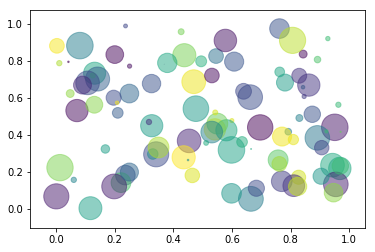

In [1]:
%matplotlib inline 
"""
Simple demo
"""
import numpy as np
import matplotlib.pyplot as plt

N=99
x=np.random.rand(N)
y=np.random.rand(N)
colors = np.random.rand(N)
area = np.pi * (15 * np.random.rand(N))**2

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()


In [2]:
import pyspark
import random
if not 'sc' in globals(): 
    sc = pyspark.SparkContext()
NUM_SAMPLES = 100000
def sample(p):
    x,y = random.random(),random.random()
    return 1 if x*x + y*y < 1 else 0
count = sc.parallelize(xrange(0, NUM_SAMPLES)) \
            .map(sample) \
            .reduce(lambda a, b: a + b)
print("Pi is roughly {0}".format(4.0 * count / NUM_SAMPLES))

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1551286420805_0003,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 57874)
----------------------------------------
Pi is roughly 3.14976
Traceback (most recent call last):
  File "/usr/lib64/python2.7/SocketServer.py", line 290, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib64/python2.7/SocketServer.py", line 318, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib64/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib64/python2.7/SocketServer.py", line 652, in __init__
    self.handle()
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/accumulators.py", line 266, in handle
    poll(authenticate_and_accum_updates)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/usr/lib/spark/python/lib

In [3]:
import pyspark
if not 'sc' in globals(): 
    sc = pyspark.SparkContext()
text_file = sc.textFile("s3://boll0107-movielens-data/README.txt")
counts = text_file.flatMap(lambda line: line.split(" ")) \
                    .map(lambda word: (word, 1)) \
                    .reduceByKey(lambda a, b: a + b)
i = 0
for x in counts.collect():
    if i < 10: 
        print(x)
        i = i + 1
    else: 
        break

VBox()

(u'', 78)
(u'=======', 1)
(u'all', 2)
(u'commas', 1)
(u'(TiiS)', 1)
(u'Harper', 1)
(u'over', 1)
(u'movies.', 3)
(u'(UTC)', 2)
(u'four', 1)

In [4]:
# Now try to get the keys back in SORTED order (sortByKey(False) gives Descending order)
import pyspark
if not 'sc' in globals(): 
    sc = pyspark.SparkContext()
text_file = sc.textFile("s3://boll0107-movielens-data/README.txt")
counts = text_file.flatMap(lambda line: line.split(" ")) \
                    .map(lambda word: (word, 1)) \
                    .reduceByKey(lambda a, b: a + b) \
                    .map(lambda (x,y): (y,x)).sortByKey(False)
i = 0
for x in counts.collect():
    if i < 10: 
        print(x)
        i = i + 1
    else: 
        break

VBox()

(78, u'')
(64, u'the')
(39, u'of')
(29, u'*')
(27, u'and')
(21, u'are')
(18, u'is')
(17, u'to')
(16, u'for')
(16, u'or')

In [5]:
ratings=spark.read.option("header","true").csv("s3://boll0107-movielens-data/ml-latest-small/ratings.csv")
movies=spark.read.option("header","true").csv("s3://boll0107-movielens-data/ml-latest-small/movies.csv")
tags=spark.read.option("header","true").csv("s3://boll0107-movielens-data/ml-latest-small/tags.csv")

VBox()

In [6]:
ratings.show(5)

VBox()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

In [7]:
# Prepare the views for query with SQL
ratings.createOrReplaceTempView("ratings")
movies.createOrReplaceTempView("movies")
tags.createOrReplaceTempView("tags")
from pyspark.sql.functions import regexp_extract


VBox()

In [8]:
movies.show(5)

VBox()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

In [9]:
help(regexp_extract)

VBox()

Help on function regexp_extract in module pyspark.sql.functions:

regexp_extract(str, pattern, idx)
    Extract a specific group matched by a Java regex, from the specified string column.
    If the regex did not match, or the specified group did not match, an empty string is returned.
    
    >>> df = spark.createDataFrame([('100-200',)], ['str'])
    >>> df.select(regexp_extract('str', r'(\d+)-(\d+)', 1).alias('d')).collect()
    [Row(d=u'100')]
    >>> df = spark.createDataFrame([('foo',)], ['str'])
    >>> df.select(regexp_extract('str', r'(\d+)', 1).alias('d')).collect()
    [Row(d=u'')]
    >>> df = spark.createDataFrame([('aaaac',)], ['str'])
    >>> df.select(regexp_extract('str', '(a+)(b)?(c)', 2).alias('d')).collect()
    [Row(d=u'')]
    
    .. versionadded:: 1.5

In [10]:
movies_year = movies.withColumn("Year",regexp_extract("title", "^(.*) \((\d+)\)", 2))
movies_year.show(5,False)

VBox()

+-------+----------------------------------+-------------------------------------------+----+
|movieId|title                             |genres                                     |Year|
+-------+----------------------------------+-------------------------------------------+----+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|1995|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |1995|
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |1995|
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |1995|
|5      |Father of the Bride Part II (1995)|Comedy                                     |1995|
+-------+----------------------------------+-------------------------------------------+----+
only showing top 5 rows

In [11]:
type(movies_year)

VBox()

<class 'pyspark.sql.dataframe.DataFrame'>

In [12]:
movies_year.write.option("header", "true").mode("overwrite") \
        .csv("s3://boll0107-movielens-data/output/movies_year.csv")


VBox()

In [13]:
year_load=spark.read.option("header","true").csv("s3://boll0107-movielens-data/output/movies_year.csv")
year_load.show(5)

VBox()

+-------+--------------------+--------------------+----+
|movieId|               title|              genres|Year|
+-------+--------------------+--------------------+----+
|      1|    Toy Story (1995)|Adventure|Animati...|1995|
|      2|      Jumanji (1995)|Adventure|Childre...|1995|
|      3|Grumpier Old Men ...|      Comedy|Romance|1995|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|1995|
|      5|Father of the Bri...|              Comedy|1995|
+-------+--------------------+--------------------+----+
only showing top 5 rows

## Borrowed Snippets from https://github.com/PiyushShinde/Spark-and-Python-for-Big-Data-with-PySpark/blob/master/Recommendation%20System%20-%20MovieLens%20Data.ipynb

In [14]:
data = spark.read.csv('s3://boll0107-movielens-data/ml-latest-small/ratings.csv',inferSchema=True,header=True)
data.head().asDict()
data.describe().show()



VBox()

+-------+------------------+----------------+------------------+--------------------+
|summary|            userId|         movieId|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------+------------------+--------------------+

In [15]:
from pyspark.sql.functions import isnan, isnull, when, count, col

data.select([count(when(isnan(c)| isnull(c), c)).alias(c) for c in data.columns]).show()

VBox()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+

In [16]:
# Split the data into train and test set to evaluate the performance of our recommendation system
train, test = data.randomSplit([0.9, 0.1])

VBox()

In [17]:
# Import ALS

from pyspark.ml.recommendation import ALS
# Build the recommendation model using ALS on the training data
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating")
model = als.fit(train)

VBox()

In [18]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
predictions.show()

VBox()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   385|    471|   4.0| 850766697| 2.8196707|
|   603|    471|   4.0| 954482443| 3.1308668|
|   182|    471|   4.5|1054779644|  4.687266|
|   387|    471|   3.0|1139047519| 3.6810222|
|   555|    471|   3.0| 978746933|  4.957922|
|   260|    471|   4.5|1109409455| 2.6447413|
|   104|    471|   4.5|1238111129| 3.6721296|
|   563|   1088|   4.0|1440793700| 3.7966042|
|   600|   1088|   3.5|1237851304| 2.4535122|
|    19|   1238|   3.0| 965705784|  3.568764|
|    19|   1342|   2.0| 965704952| 2.7282286|
|   580|   1580|   4.0|1167792444|  3.482589|
|   183|   1580|   4.0| 992331667|  4.053809|
|   330|   1580|   4.0|1285905069|  3.486243|
|    93|   1580|   5.0| 942767007| 4.5511866|
|   233|   1580|   3.0|1529334057| 3.1106882|
|   542|   1580|   3.5|1163386854| 3.9929576|
|   590|   1580|   3.5|1258420589| 3.1455793|
|   220|   1580|   5.0|1230055820|

In [19]:
# Import evaluator

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root mean square error = " + str(rmse))

VBox()

Root mean square error = nan

In [20]:
single_user = test.filter(test['userId']==11).select(['movieId','userId','rating'])
# Check which movies userId '11' has seen from the test set and then train set
single_user.show()
train.filter(test['userId']==1).select(['movieId','userId','rating']).show()

VBox()

+-------+------+------+
|movieId|userId|rating|
+-------+------+------+
|     36|    11|   4.0|
|    208|    11|   3.0|
|    376|    11|   2.0|
|    466|    11|   3.0|
|   1100|    11|   3.0|
|   1101|    11|   5.0|
|   1586|    11|   4.0|
|   1597|    11|   4.0|
|   2028|    11|   5.0|
+-------+------+------+

+-------+------+------+
|movieId|userId|rating|
+-------+------+------+
|      1|     1|   4.0|
|      3|     1|   4.0|
|      6|     1|   4.0|
|     47|     1|   5.0|
|     50|     1|   5.0|
|     70|     1|   3.0|
|    101|     1|   5.0|
|    110|     1|   4.0|
|    151|     1|   5.0|
|    157|     1|   5.0|
|    163|     1|   5.0|
|    216|     1|   5.0|
|    223|     1|   3.0|
|    231|     1|   5.0|
|    235|     1|   4.0|
|    260|     1|   5.0|
|    296|     1|   3.0|
|    316|     1|   3.0|
|    333|     1|   5.0|
|    356|     1|   4.0|
+-------+------+------+
only showing top 20 rows